In [133]:
from qdrant_client import QdrantClient
from qdrant_client.models import PointStruct
from qdrant_client.http import models

from qdrant_client import QdrantClient
from qdrant_client.http.models import (CollectionDescription, 
VectorParams, 
Distance, Filter, FieldCondition, Match, PointRequest, MatchValue)
import sqlite3

client = QdrantClient(host="sprakbankdb1.lx.nb.no", port=6333)


In [5]:
import importlib

In [6]:
import image2vec as iv

In [30]:
from PIL import Image

In [14]:
import re
from IPython.display import HTML

def display_finds(r, num_rows, num_columns, width=500):
    """A list of urls in r is displayed in a grid layout with specified number of rows and columns."""
    base = "https://www.nb.no/items/"
    # Initialize the rows list which will contain HTML string for each row
    rows_html = []
    # Calculate total number of items to display, based on the specified rows and columns
    total_items = num_rows * num_columns
    # Ensure we don't try to display more items than we have
    r = r[:total_items]
    
    # Split the list into rows with the specified number of columns
    for row_start in range(0, len(r), num_columns):
        row_items = r[row_start:row_start+num_columns]
        # For each row, create a list of cell HTML strings
        cells_html = []
        for i, item in enumerate(row_items):
            urnstring = re.findall("URN[^/]*", item)[0]
            prefix, doctyp, urn, page = urnstring.split('_')
            cell_html = f"<td><a href='{base}{prefix}_{doctyp}_{urn}?page={int(page) + 1}' target='_'><img src='{item}' width={width}></a>{row_start+i}</td>"
            cells_html.append(cell_html)
        # Join the cell HTML strings into a row and add it to the rows list
        rows_html.append(f"<tr>{' '.join(cells_html)}</tr>")

    # Join all rows into the final HTML table
    html_table = f"<table>{' '.join(rows_html)}</table>"
    return HTML(f"""<html><head></head><body>{html_table}</body></html>""")


In [15]:
import numpy as np

In [16]:
collection_name = "images_1900_cos"

In [17]:
db = "../Bildevektor/all_images.db"

In [18]:
def query(db, sql, params=()):
    with sqlite3.connect(db) as con:
        r = con.execute(sql, params).fetchall()
    return r

In [21]:
#vec[0]

In [90]:
from importlib import reload
reload(iv)

<module 'image2vec' from '/mnt/disk1/Github/Qdrant/image2vec.py'>

In [64]:
import pandas as pd

In [119]:
def find_similar_vec(vector=None, collection_name=None, num=20):
    hits = client.search(
       collection_name = collection_name,
       query_vector = vector,
       limit = num  # 
    )
    return hits

In [ ]:
def find_similar_image_url(image_url=None, collection_name=None, num=20):
    hits = client.search(
       collection_name = collection_name,
       query_vector = vector,
       limit = num  # 
    )
    return hits

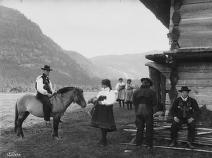

In [115]:
pointer = "https://www.nb.no/items/1a2d8f2f332c7a0c2b5693cabe96cadd?page=0&searchText=lindahl"
res = pd.DataFrame(iv.fetch_meta(pointer))

url = res[res.label.str.contains("lenke")]['value'].values[0]

a = iv.foto_url(url)

image = Image.open(iv.load_picture(a)['result'])
vec = iv.encode_image(image)
image

In [123]:
#res = query(db, "select * from metadata order by random() limit 1 ")
hits = find_similar_vec(vec[0], collection_name=collection_name, num = 30)
display_finds([x.payload['url'] for x in hits], 10, 4)
[x.payload[k] for x in hits[0:2] for k in x.payload.keys() ]

['273,451,2543,3634',
 'https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2015090729005_0151/273,451,2543,3634/317,/0/default.jpg',
 'URN:NBN:no-nb_digibok_2015090729005_0151',
 '582,1015,6326,3383',
 'https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2009040611002_0091/582,1015,6326,3383/790,422/0/default.jpg',
 'URN:NBN:no-nb_digibok_2009040611002_0091']

In [158]:

page_urn = "URN:NBN:no-nb_digibok_2015062608011_0361"
def find_images_urn(page_urn):
    # Construct the filter for the search query
    payload_filter = Filter(
        must=[
            FieldCondition(
                key="urn",  # Ensure this is the correct key name in your payload
                match={"value": page_urn}         
            )
        ]
    )
    
    # Perform the search
    search_results = client.scroll(
        collection_name=collection_name,
        scroll_filter=payload_filter,
        limit=100  # Adjust the limit based on how many results you expect
    )
    
    # Output the results
    records, _ = search_results
    return [x.payload['url'] for x in records]

In [159]:
find_images_urn(page_urn)

['https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2015062608011_0361/507,564,1524,2635/381,/0/default.jpg']

In [146]:
res = pd.DataFrame(iv.fetch_meta("https://www.nb.no/items/d1352624a2cb4dc57e0a8620168671f8?page=0&searchText=lindahl"))

In [176]:
def show_collections(client):
    collections = client.get_collections()
    return [collection.name for collection in collections.collections]


In [177]:
show_collections(client)

['vss_1850_cos',
 'vss_dewey_code',
 'vss_1800_cos',
 'vss_dewey',
 'images_1900_cos']